## Readin In Covid-19 Pandemic Data from Wikidata.org
Alexander Jung, April 2020 


This notebook reads in the time series of Covid-19 infections from Wikidata. It reads in the most recent numbers of infections reported on wikidata. For each country with a sufficient number of recent days with reported cases, we compute the average increase between consecutive reportings (typically for consecutive days but there might be reporting errors). Moreover, we also compute the standard deviation of these increases in reported cases for each country. 

The data is fetched from the wikidata knowledge base (https://www.wikidata.org/wiki/Wikidata:Main_Page). 


In [1]:
import requests
import pandas as pd
from collections import OrderedDict
import matplotlib.pyplot as plt
import datetime

# read in cases from wikidata entry Q86847911 ("2020 coronavirus outbreak in Austria")

In [2]:

### the following constructs a "sparl" query for wikidata 
### the query selects entries ?item that are an instance (P31) of "disease outbreak" (Q3241045) 
### as well as being a facet of (P1269) of "2019–20 COVID-19 pandemic" Q81068910 and 
### a part of (P361) "2019–20 coronavirus pandemic by country and territory" (Q83741704)
### it then selects any reported number of cases P1603 

#  ?item wdt:P31 wd:Q3241045.
url = 'https://query.wikidata.org/sparql'
query = """
SELECT
?casesPointInTime ?cases ?countryLabel
WHERE {
  ?item wdt:P31 wd:Q3241045.
  ?item wdt:P17 ?country.
  ?item p:P1603 ?casesStatement.
  ?casesStatement ps:P1603 ?cases.
  FILTER(?cases > 0)
  ?casesStatement pq:P585 ?casesPointInTime.
  { ?item wdt:P1269 wd:Q81068910. } UNION
  { ?item wdt:P361 wd:Q83741704. }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en". }
}
"""

r = requests.get(url, params={'format': 'json', 'query': query}) #execute the query
rawdata = r.json()

listofreportings = []
# generate a list whose entries are dictionaries with keys time, nrcases and country 

for item in rawdata['results']['bindings']:
    listofreportings.append(OrderedDict({'time': item['casesPointInTime']['value'],
'nrcases': item['cases']['value'],
'country': item['countryLabel']['value']
}))
    


In [12]:
import numpy as np 

duration = 30  # consider average increase over last 30 days for which infections have been reported

df_wikidata=pd.DataFrame(listofreportings)    # parse the rawdata into a pandas dataframe 
df_wikidata.sort_values('country')             # sort the case reportings according to country
country_list = df_wikidata['country'].values   # read out the list of countries for each reporting
df_wikidata['time'] = df_wikidata['time'].apply(lambda x: 
                                    datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%SZ'))
df_wikidata['nrcases'] = df_wikidata['nrcases'].apply(lambda x: 
                                    float(x))

country_list = np.unique(country_list)   # find the list of countries for which at least one reporting is available

finaldataset = []   # finaldataset is a dataframe with columns country, average, std
#print(country_list)

timeseries = np.zeros((duration,1)) ; 
rawfinal = np.zeros((duration,1)); 
pd.set_option('display.max_rows',100);

for country_iter in country_list: 
    df_dmy=df_wikidata.copy()
    df_dmy =df_dmy.loc[df_dmy['country'] == country_iter]
    df_dmy=df_dmy[['time','nrcases']]
    df_dmy=df_dmy.sort_values('time', ascending=True)
    df_dmy = df_dmy.groupby('time').max().reset_index()   # agregate several reportings for the same day 
 
    timepoint = df_dmy['time'].values
    cases = df_dmy['nrcases'].values
    ts = pd.Series(cases,timepoint)
    
    
    if cases.size > duration:
        raw = cases[-duration::1]
        raw1= cases[-(duration+1):-1:1]
        increase=np.true_divide(raw,raw1)    # compute the ratios of case numbers between consecutive reportings 
        rawfinal=np.hstack([rawfinal,np.reshape(raw,(-1,1))])
        timeseries = np.hstack([timeseries,np.reshape(increase, (-1,1))])
        average =np.mean(increase)           # compute mean of reatios over most recent days
        avgpercent = 100*(average-1)
        variance=np.std(increase)            # compute standard deviation of ratios over most recent days 
        finaldataset.append(OrderedDict({'country': country_iter,
'average': avgpercent, 'std':variance, 'dmy': 0
}))
       # if country_iter=='Austria':
          #  display(df_dmy)
         #   print(cases.size)

rawfinal=rawfinal[:,1::]
timeseries=timeseries[:,1::]
finaldata =pd.DataFrame(finaldataset)
print(finaldata)


                       country    average       std  dmy
0                    Australia  31.528887  1.206048    0
1                      Austria   7.055784  0.069871    0
2                        Chile  22.760762  0.191038    0
3                     Colombia  10.491167  0.066310    0
4               Czech Republic  19.707903  0.164671    0
5                      Ecuador  23.893746  0.233740    0
6                         Fiji   8.549603  0.174715    0
7                       France  16.880702  0.548113    0
8                      Germany   6.490814  0.046611    0
9                       Greece   5.009849  0.041527    0
10                     Hungary   9.846712  0.060528    0
11                       India  43.293821  0.858922    0
12                        Iran   4.920442  0.026418    0
13                       Italy   4.173493  0.024240    0
14                       Japan   8.293107  0.029517    0
15                  Luxembourg   5.909315  0.064633    0
16                 Netherlands 

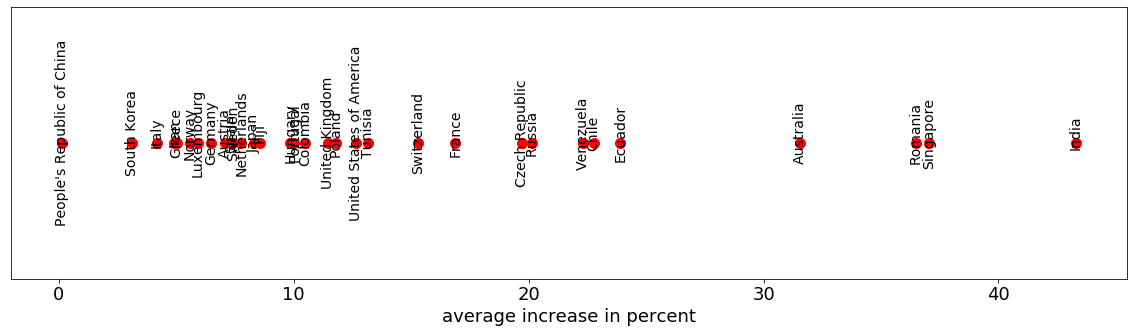

In [31]:
finaldata.plot(kind='scatter',x='average',y='dmy',s=100,color='red',figsize=(20, 5))
frame = plt.gca()

frame.axes.set_xlabel('average increase in percent', fontsize=18)

frame.get_yaxis().set_visible(False)
frame.axes.tick_params(axis='x', labelsize=18)
for x,y,label in zip(finaldata['average'].values,finaldata['dmy'].values,finaldata['country']):

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',va='center',rotation=90,fontsize=14) # horizontal alignment can be left, right or center


plt.show()

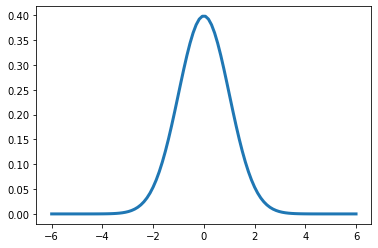

In [35]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = 0
variance = 1
sigma = math.sqrt(variance)
x = np.linspace(mu - 6*sigma, mu + 6*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma), linewidth=3)
plt.show()

0                      Australia
1                        Austria
2                          Chile
3                       Colombia
4                 Czech Republic
5                        Ecuador
6                           Fiji
7                         France
8                        Germany
9                        Hungary
10                         India
11                          Iran
12                         Italy
13                         Japan
14                    Luxembourg
15                   Netherlands
16                        Norway
17    People's Republic of China
18                        Poland
19                      Portugal
20                       Romania
21                        Russia
22                     Singapore
23                   South Korea
24                         Spain
25                        Sweden
26                   Switzerland
27                       Tunisia
28                United Kingdom
29      United States of America
30        

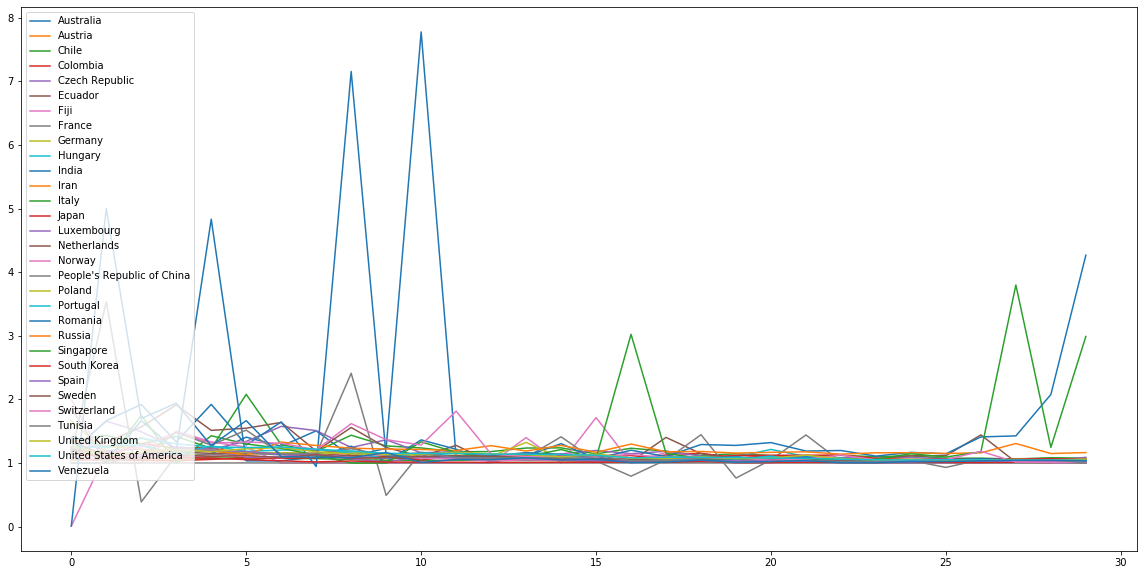

In [13]:
print(finaldata['country'])
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(np.arange(duration),timeseries)
ax.legend(finaldata['country'])

France


[ 14459.  51100.  19856.  22302.  25233.  29155.  32964.  37575.  90607.
  44550.  52128.  56989.  59105.  64338.  90848.  93773.  74390.  78167.
 112950.  86334.  90676. 130730. 133669. 137873. 143303. 133470. 140772.
 147969. 151793. 152894.]
[5, 10, 15, 30]


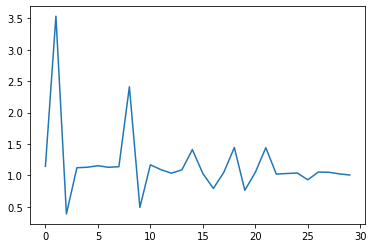

In [16]:
import numpy as np
import scipy
import ruptures as rpt

model = "l2"  # "l1", "rbf", "linear", "normal", "ar"

# generate signal
n_samples, dim, sigma = 1000, 3, 4
n_bkps = 1  # number of breakpoints
signal, bkps = rpt.pw_constant(n_samples, dim, n_bkps, noise_std=sigma)

ctryidx=7

signal = timeseries[:,ctryidx]
print(finaldata['country'][ctryidx])
print("\n")
print(rawfinal[:,ctryidx])


algo = rpt.Binseg(model=model).fit(signal)
my_bkps = algo.predict(n_bkps=3)

print(my_bkps)
# display
plt.plot(signal)

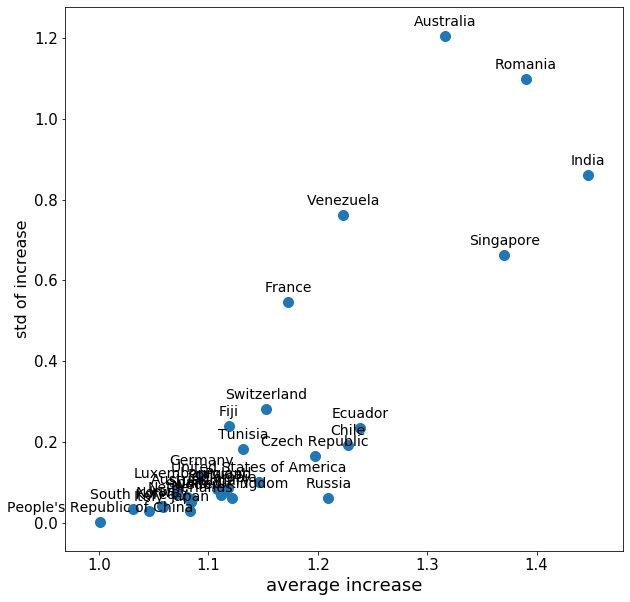

In [7]:
ax = finaldata.plot.scatter(x='average',y='std',s=100,figsize=(10,10), fontsize=15)

xs = finaldata['average'].values
ys = finaldata['std'].values
country = finaldata['country']

plt.xlabel('average increase', fontsize=18)
plt.ylabel('std of increase', fontsize=16)

# zip joins x and y coordinates in pairs
for x,y,label in zip(xs,ys,country):

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',fontsize=14) # horizontal alignment can be left, right or center


plt.show()


(30, 2)


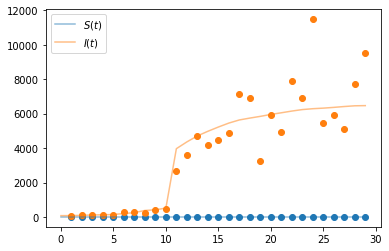

In [9]:
import pymc3 as pm
from pymc3.ode import DifferentialEquation
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import arviz as az
import theano

def SIR(y, t, p):
    ds = -p[0]*y[0]*y[1]
    di = p[0]*y[0]*y[1] - p[1]*y[1]
    return [ds, di]

#times = np.arange(0,5,0.25)
times =np.arange(duration)
    
beta,gamma = 4,1.0
# Create true curves
y = odeint(SIR, t=times, y0=[0.99, 0.01], args=((beta,gamma),), rtol=1e-8)
y = timeseries[:,0:2]
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[1::]), sigma=[0.2, 0.3])

print(y.shape)

plt.plot(times[1::],yobs, marker='o', linestyle='none')
plt.plot(times, y[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [14]:
sir_model = DifferentialEquation(
    func=SIR,
    times=np.arange(0.25, 5, 0.25),
    n_states=2,
    n_theta=2,
    t0=0,
)

with pm.Model() as model4:
    sigma = pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0 = pm.Bound(pm.Normal, lower=1)('R0', 2,3)
    lam = pm.Lognormal('lambda',pm.math.log(2),2)
    beta = pm.Deterministic('beta', lam*R0)

    sir_curves = sir_model(y0=[0.99, 0.01], theta=[beta, lam])

    Y = pm.Lognormal('Y', mu=pm.math.log(sir_curves), sd=sigma, observed=yobs)

    prior = pm.sample_prior_predictive()
    trace = pm.sample(2000,tune=1000, target_accept=0.9, cores=1)
    posterior_predictive = pm.sample_posterior_predictive(trace)

    data = az.from_pymc3(trace=trace, prior = prior, posterior_predictive = posterior_predictive)



Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [lambda, R0, sigma]
100%|██████████| 4000/4000 [03:50<00:00, 17.37it/s]


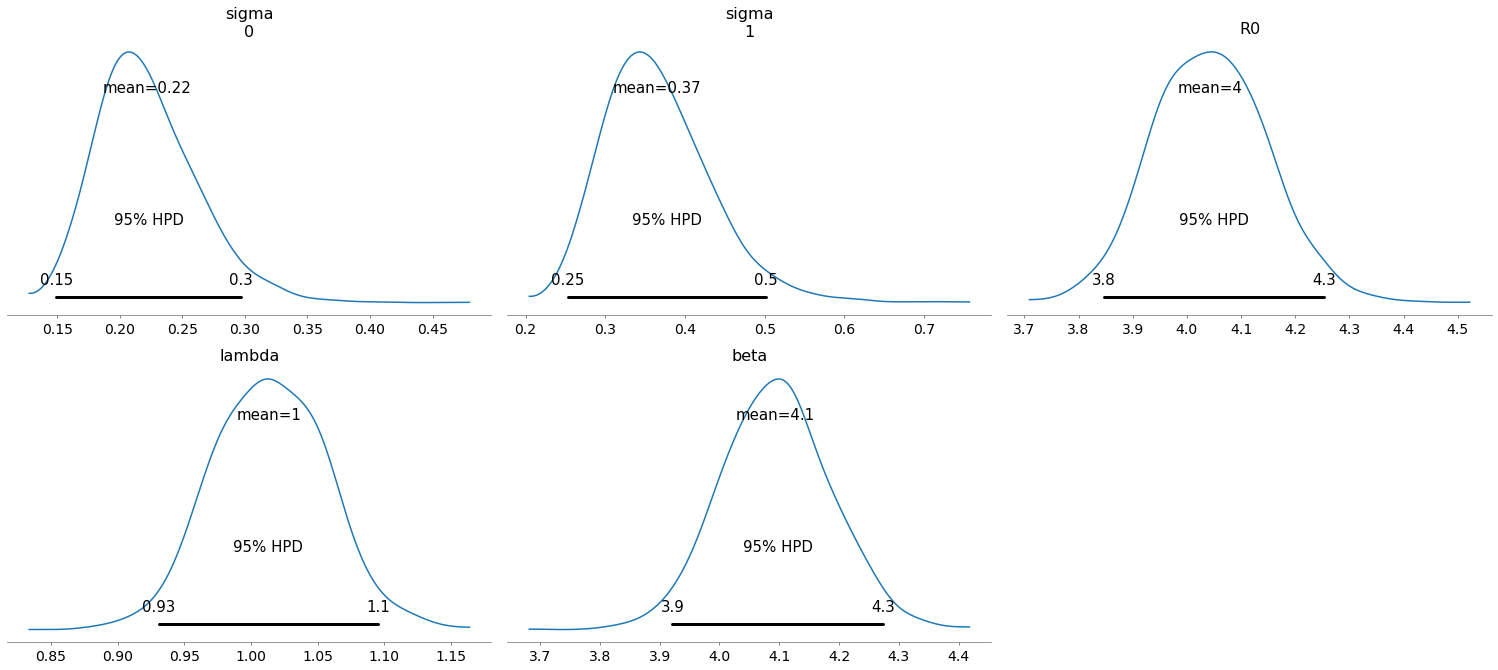

In [15]:

az.plot_posterior(data,round_to=2, credible_interval=0.95);

